In [2]:
import os
import random
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader, Dataset
import math
from typing import Tuple
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import matplotlib.pyplot as plt
import torch.optim as optim


def seed_everything(val):
    """ For reproducibility - Seeds all relevant random generators to the same value. """
    random.seed(val)
    os.environ['PYTHONHASHSEED'] = str(val)
    np.random.seed(val)
    torch.manual_seed(val)
    torch.cuda.manual_seed(val)
    torch.cuda.manual_seed_all(val)
    torch.backends.cudnn.deterministic = True
    print('Manual seed changed successfully.')


""" DO NOT CHANGE THE SEED! """
seed = 42
seed_everything(seed)







Manual seed changed successfully.


In [3]:
from collections import Counter
from torch.utils.data import Dataset

class Corpus(Dataset):
    def __init__(self, file_name):
        self.words = self.load_words(file_name)
        self.uniq_words = self.get_uniq_words()
        self.create_mappings()

    def load_words(self, file_name):
        with open(file_name, encoding='utf_8') as file:
            text = file.read().replace('\n', '<eos>')
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def create_mappings(self):
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

    def process_sequence(self, words):
        processed_sequence = torch.tensor([self.word_to_index[word] for word in words])
        return processed_sequence

    def __getitem__(self, index):
        return self.process_sequence(self.words[index])

    def __len__(self):
        return len(self.words)

def batchify(data, batch_size):
    seq_len = len(data) // batch_size
    data = data[:seq_len * batch_size]
    data = data.view(batch_size, seq_len).t().contiguous()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return data.to(device)

In [4]:
train_dataset = Corpus('wikitext-2/wiki.train.tokens')
valid_dataset = Corpus('wikitext-2/wiki.valid.tokens')
test_dataset = Corpus('wikitext-2/wiki.test.tokens')

train_data = train_dataset.process_sequence(train_dataset.words, train_dataset.word_to_index)
val_data = valid_dataset.process_sequence(valid_dataset.words, train_dataset.word_to_index)
test_data = test_dataset.process_sequence(test_dataset.words, train_dataset.word_to_index)
batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)
val_data = batchify(val_data, batch_size)
test_data = batchify(test_data, batch_size)

Define the model


In [5]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)




        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)


        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

PositionalEncoding

In [6]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        position_encoding = torch.zeros(max_len, 1, d_model)
        position_encoding[:, 0, 0::2] = torch.sin(position * div_term)
        position_encoding[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('position_encoding', position_encoding)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.position_encoding[:x.size(0)]
        return self.dropout(x)

## Load and batch data




`




In [7]:
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

 Initiate an instance

In [8]:
ntokens = len(train_dataset.uniq_words)
emsize = 200
d_hid = 200
bptt = 35
nlayers = 2
dropout = 0.2
nhead = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

Run the model

In [9]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [ ]:
best_val_loss = float('inf')
epochs = 1
best_model = None
l_train_ppl=[]
l_val_ppl=[]
l_epo=[]
lr_old='-1'
l_lr=[]
for epoch in range(0, epochs ):
    epoch_start_time = time.time()
    train(model)
    ###################
    train_loss = evaluate(model, train_data)
    train_ppl = math.exp(train_loss)
    ############################
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)
    ##########################
    l_train_ppl.append(train_ppl)
    l_val_ppl.append(val_ppl)
    l_epo.append(epoch)


    lr_new=scheduler.get_last_lr()[0]
    if lr_new!= lr_old:
        l_lr.append(lr_new)
        lr_new=lr_old
    else:
        l_lr.append(0)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

Evaluate the best model on the test dataset

In [12]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.82 | test ppl   335.42


In [ ]:
path = 'trained_RNN.pt'
torch.save(best_model.state_dict(), path)

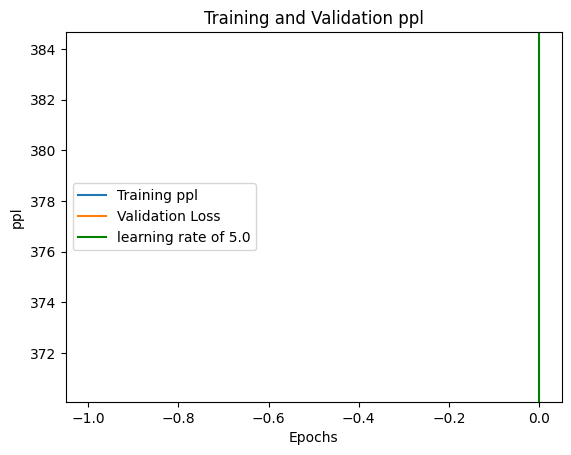

In [13]:
from matplotlib.pylab import plt

l_epo = list(map(lambda item: item - 1, l_epo))
plt.plot(l_epo, l_train_ppl, label='Training ppl')
plt.plot(l_epo, l_val_ppl, label='Validation Loss')
plt.title('Training and Validation ppl')
plt.xlabel('Epochs')
plt.ylabel('ppl')
for line in range(len(l_lr)):
    plt.axvline(line, 0, l_lr[line],c='green', label=f'learning rate of {l_lr[line]}')
plt.legend(loc='best')
plt.show()

In [104]:
from torchtext.vocab import Vocab
import random
def predict_and_explore(model, dataset, seq_len,num_of_sentences):
    model.eval()
    l_sequenses=[]
    i_p_words=[]
    for i in range(num_of_sentences):

        random_start = random.randint(0, len(dataset.index_to_word)-seq_len-1)
        src_mask = generate_square_subsequent_mask(seq_len).to(device)
        data = dataset.process_sequence(dataset.words,dataset.word_to_index)[random_start:random_start+seq_len]
        output = model(data, src_mask)
        logits = output[0][0]
        sequenses = ' '.join(dataset.words[random_start:random_start+seq_len])
        l_sequenses.append(sequenses)
        print(f"Sentnce {i} is: {sequenses}")
        print(f" and the predicted word is one of the followig:")
        top_predictions, top_indices = torch.topk(logits, 20)
        oo=0
        for idx in top_indices:
            if oo<6:
                k=idx.item()
                new_word=dataset.index_to_word[k]
                if new_word.isalpha() and not  new_word in i_p_words:
                    i_p_words.append(dataset.index_to_word[k])
                    print(f"{oo} {dataset.index_to_word[k]}")
                    oo=oo+1
predict_and_explore(best_model, train_dataset, 7,3)

Sentnce 0 is: mother and sister the care they needed
 and the predicted word is one of the followig:
0 of
1 and
2 in
3 is
4 to
5 was
Sentnce 1 is: . However , the lottery was won
 and the predicted word is one of the followig:
0 The
1 In
2 He
3 It
4 On
5 A
Sentnce 2 is: above the Gallery of Maps , which
 and the predicted word is one of the followig:
0 a
1 his
2 the
3 that
4 this
5 its


In [107]:
save_path = 'wikitext2_trained.pt'
torch.save(best_model.state_dict(), save_path)
ptb = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
ptb.load_state_dict(torch.load(save_path))
for param in ptb.parameters():
    param.requires_grad = False
ptb.decoder = nn.Linear(ptb.decoder.in_features,len(train_dataset.uniq_words))
ptb = ptb.to(device)
PTB_train_dataset = Corpus('ptb.train.txt')
PTB_valid_dataset = Corpus('ptb.valid.txt')
PTB_test_dataset = Corpus('ptb.test.txt')

PTB_train_data = train_dataset.process_sequence(PTB_train_dataset.words,PTB_train_dataset.word_to_index)
PTB_val_data = valid_dataset.process_sequence(PTB_valid_dataset.words,PTB_valid_dataset.word_to_index)
PTB_test_data = test_dataset.process_sequence(PTB_test_dataset.words,PTB_test_dataset.word_to_index)
batch_size = 20
eval_batch_size = 10
PTB_train_data = batchify(PTB_train_data,batch_size)
PTB_val_data = batchify(PTB_val_data,batch_size)
PTB_test_data = batchify(PTB_test_data,batch_size)

In [108]:
PTB_mean_epoch_train_ppl=[]
optimizer = torch.optim.SGD(ptb.decoder.parameters(), lr=lr)

def PTB_train(model: nn.Module) -> None:
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    train_ppl=[]
    num_batches = len(PTB_train_data) // bptt
    for batch, i in enumerate(range(0, PTB_train_data.size(0) - 1, bptt)):
        data, targets = get_batch(PTB_train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # only on last batch
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            train_ppl.append(ppl)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

    PTB_mean_epoch_train_ppl.append(np.mean(train_ppl))

In [ ]:
PTB_best_val_loss = float('inf')
epochs = 5
PTB_best_model = None
lr = 5.0
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

PTB_val_ppl=[]

for epoch in range(0, epochs):
    epoch_start_time = time.time()
    PTB_train(ptb)
    val_loss = evaluate(ptb, PTB_val_data)
    PTB_val_ppl.append(math.exp(val_loss))
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | valid loss {val_loss:5.2f} | valid ppl {PTB_val_ppl[epoch]:8.2f}')
    print('-' * 89)

    if val_loss < PTB_best_val_loss:
        PTB_best_val_loss = val_loss
        PTB_best_model = copy.deepcopy(ptb)

    scheduler.step()

In [ ]:
save_path = 'wikitext2_trained.pt'
best_model=TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
best_model.load_state_dict(torch.load(save_path))
old_losss = evaluate(best_model, PTB_test_data)
old_ppl = math.exp(old_losss)
print('=' * 89)
print(f'| Before training PTB head | test loss {old_losss:5.4f} | test ppl {old_ppl:8.4f}')
print('=' * 89)

In [ ]:
test_loss = evaluate(PTB_best_model, PTB_test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training PTB head | test loss {test_loss:5.4f} | test ppl {test_ppl:8.4f}')
print('=' * 89)